In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy
from scipy.special import rel_entr

In [2]:
config = {
    'nbase': 100,
    'neca': 1000,
}

In [3]:
def plot_dist(data):
    _, ax = plt.subplots(2,2, figsize=(10, 10))
    ax[0][0].hist(data['age'])
    ax[0][1].hist(data['lab1'])
    ax[1][0].hist(data['lab2'])
    ax[1][1].hist(data['lab3'])
    plt.show()

In [4]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 3000
lab3 = 10

mean = [age, lab1, lab2]
cov = [[14, 20, 0.3], 
       [20, 100, 0.8],
       [0.3, 0.8, 5000]]

x = np.random.default_rng().multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0
x = np.concatenate((x, 5*np.random.beta(1, 2, size=config['nbase']).reshape(-1, 1)),
                   axis=1)
data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3'])

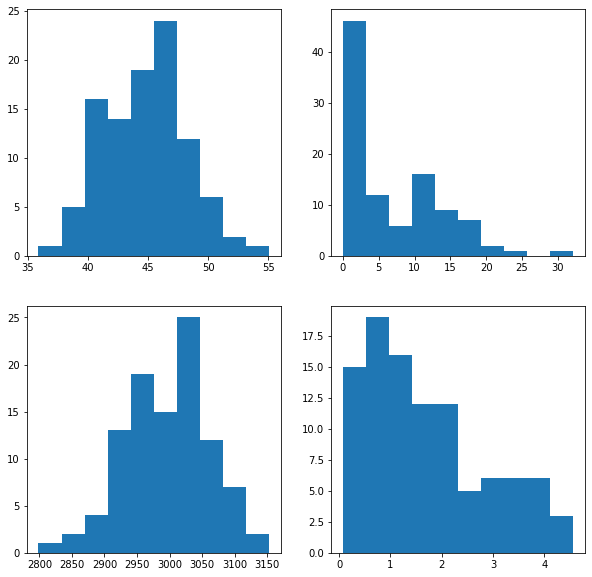

In [5]:
plot_dist(data_base)

In [6]:
# For External cohort
age = 50
lab1 = 5
lab2 = 2800
lab3 = 12

mean = [age, lab1, lab2]
cov = [[15, 11, 4], 
       [11, 30, 5],
       [4, 5, 5000]]
x = np.random.default_rng().multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0
x = np.concatenate((x, 6*np.random.beta(1.2, 0.9, size=config['neca']).reshape(-1, 1)),
                   axis=1)
data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3'])

In [7]:
data_eca = data_eca.iloc[0:-2]
xp = pd.DataFrame([[72, 12, 4000, 2], [20, 11, 2000, 3]], 
                 columns=['age', 'lab1', 'lab2', 'lab3'])
data_eca = pd.concat([data_eca, xp]).reset_index(drop=True)

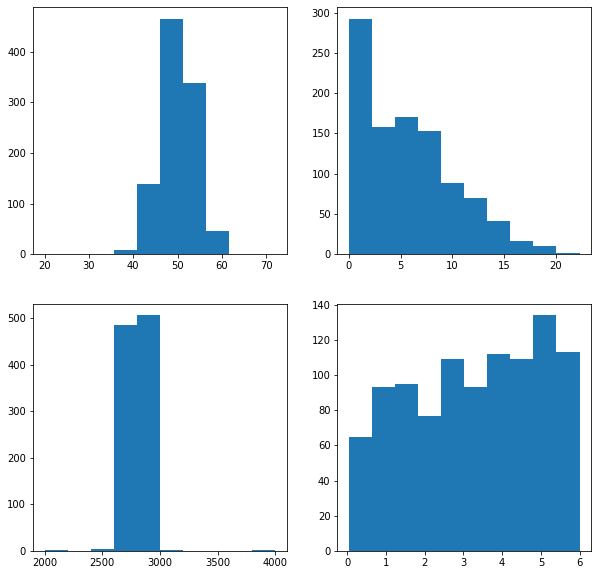

In [8]:
plot_dist(data_eca)

In [9]:
# example of calculating the kl divergence (relative entropy) with scipy
from scipy.special import rel_entr
# define distributions
p = [0.10, 0.40, 0.50]
q = [0.10, 0.40, 0.50 ]
# calculate (P || Q)
kl_pq = rel_entr(p, q)

In [10]:
sum(kl_pq)

0.0

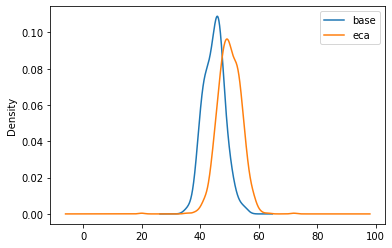

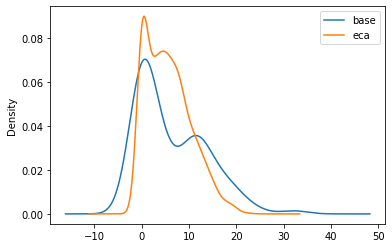

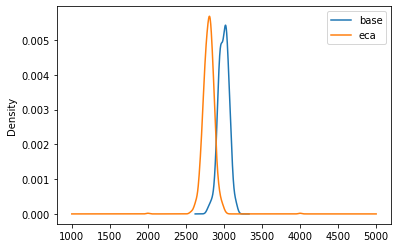

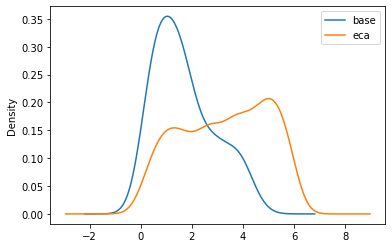

In [11]:
for i, col in enumerate(data_base.columns):
    plt.figure()
    data_base[col].plot.kde(label='base')
    data_eca[col].plot.kde(label='eca')
    plt.legend()

In [12]:
# # Normalization does not work as it disregards the scale
# for i, col in enumerate(data_base.columns):
#     plt.figure()
#     d1 = data_base[col].copy()
#     d2 = data_eca[col].copy()
    
#     d1 = (d1 - d1.min())/(d1.max() - d1.min())
#     d2 = (d2 - d2.min())/(d2.max() - d2.min())
    
#     d1.plot.kde(label='base')
#     d2.plot.kde(label='eca')
#     plt.legend()

In [13]:
density_age = scipy.stats.gaussian_kde(data_base['age'])
density_lab1 = scipy.stats.gaussian_kde(data_base['lab1'])
density_lab2 = scipy.stats.gaussian_kde(data_base['lab2'])
density_lab3 = scipy.stats.gaussian_kde(data_base['lab3'])
max_age, min_age = data_base['age'].max(), data_base['age'].min()
max_lab1, min_lab1 = data_base['lab1'].max(), data_base['age'].min()
max_lab2, min_lab2 = data_base['lab2'].max(), data_base['age'].min()
max_lab3, min_lab3 = data_base['lab3'].max(), data_base['age'].min()

In [14]:
def calc_loss(w):    
    scaled_age = (data_eca['age']*w)
    est_den_age = scipy.stats.gaussian_kde(scaled_age)
    b = max(max_age, scaled_age.max())
    a = min(min_age, scaled_age.min())
    waypoints = np.linspace(a, b, 100)
    
    scaled_lab1 = (data_eca['lab1']*w)
    est_den_lab1 = scipy.stats.gaussian_kde(scaled_lab1)
    b = max(max_lab1, scaled_lab1.max())
    a = min(min_lab1, scaled_lab1.min())
    waypoints = np.linspace(a, b, 100)
    
    scaled_lab2 = (data_eca['lab2']*w)
    est_den_lab2 = scipy.stats.gaussian_kde(scaled_lab2)
    b = max(max_lab2, scaled_lab2.max())
    a = min(min_lab2, scaled_lab2.min())
    waypoints = np.linspace(a, b, 100)

    scaled_lab3 = (data_eca['lab3']*w)
    est_den_lab3 = scipy.stats.gaussian_kde(scaled_lab3)
    b = max(max_lab3, scaled_lab3.max())
    a = min(min_lab3, scaled_lab3.min())
    waypoints = np.linspace(a, b, 100)
    
    
#     loss = rel_entr(density_age(waypoints), est_den_age(waypoints))
    loss = (density_age(waypoints)- est_den_age(waypoints))**2 + \
    (density_lab1(waypoints)- est_den_lab1(waypoints))**2 + \
    (density_lab2(waypoints)- est_den_lab2(waypoints))**2 + \
    (density_lab3(waypoints)- est_den_lab3(waypoints))**2
    
    return sum(loss)

In [15]:
def noneg(x):
    return x

cons = ({'type': 'ineq',
       'fun': noneg,    
       })

In [16]:
%%time
weights = np.ones(config['neca'])

from scipy.optimize import minimize 
wopt = minimize(calc_loss, weights, constraints=cons, options= 
            {"disp":True,"maxiter":1000})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.027905070354918144
            Iterations: 16
            Function evaluations: 16027
            Gradient evaluations: 16
CPU times: user 2min 36s, sys: 369 ms, total: 2min 36s
Wall time: 2min 50s


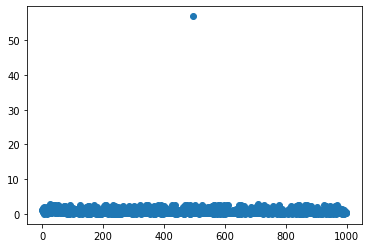

In [17]:
plt.scatter(range(config['neca']), wopt.x)

In [18]:
p = wopt.x/sum(wopt.x)

In [32]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p)

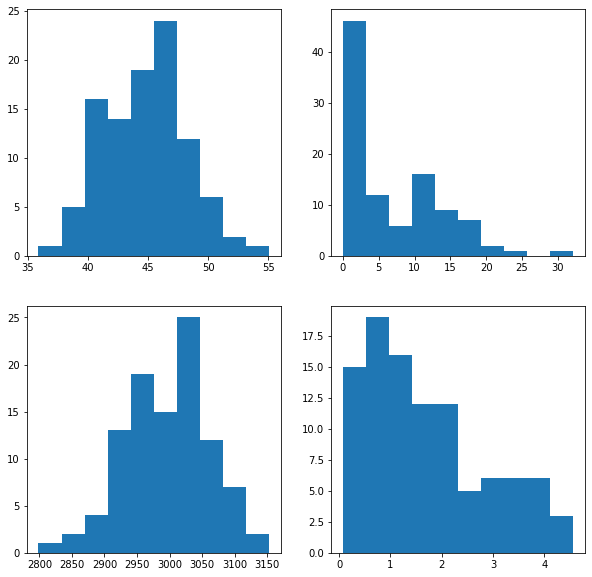

In [33]:
plot_dist(data_base)

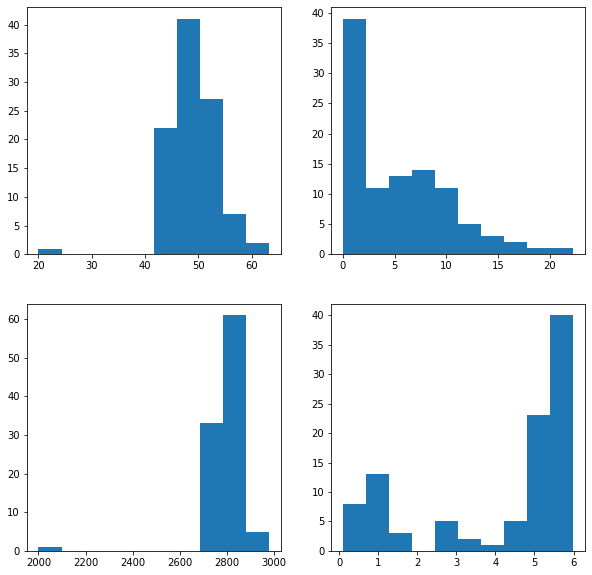

In [34]:
plot_dist(data_eca_study)

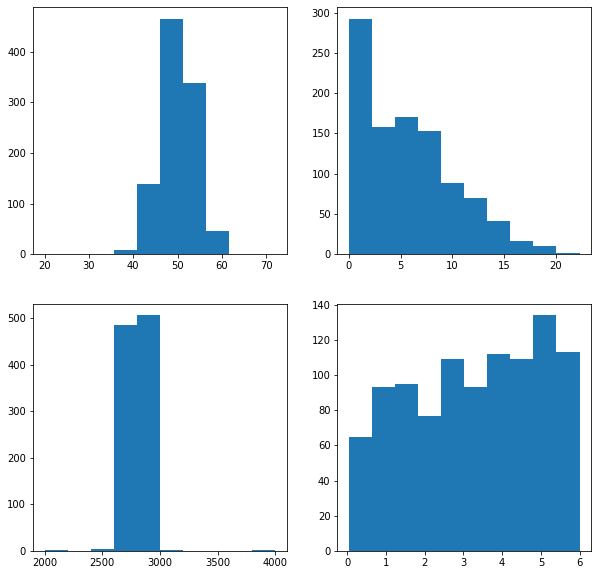

In [35]:
plot_dist(data_eca)

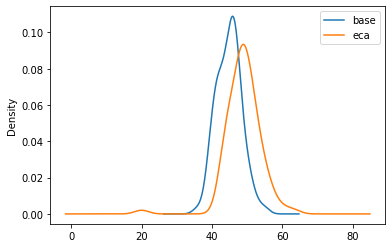

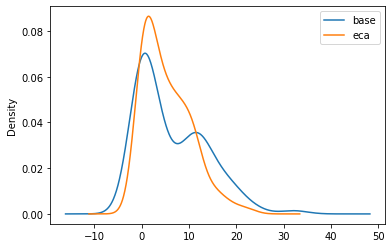

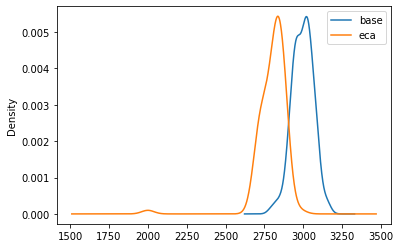

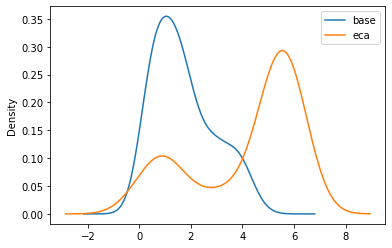

In [36]:
for i, col in enumerate(data_base.columns):
    plt.figure()
    data_base[col].plot.kde(label='base')
    data_eca_study[col].plot.kde(label='eca')
    plt.legend()

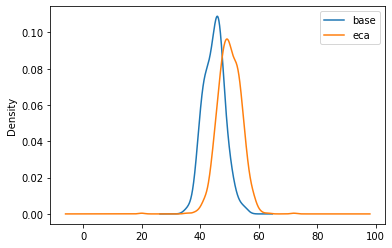

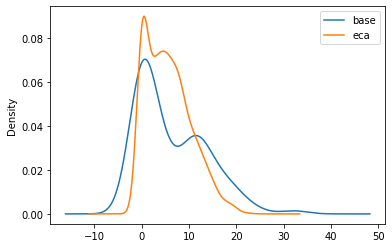

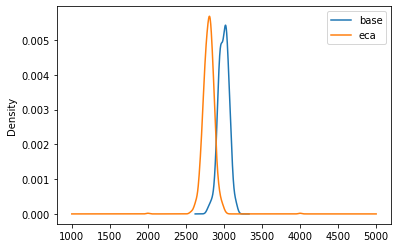

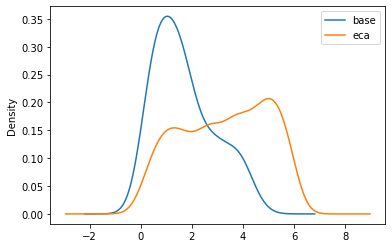

In [37]:
for i, col in enumerate(data_base.columns):
    plt.figure()
    data_base[col].plot.kde(label='base')
    data_eca[col].plot.kde(label='eca')
    plt.legend()